# 获取数据

In [1]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', as_frame=False, parser='auto')

In [2]:
X, y = mnist.data, mnist.target
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [3]:
X.shape

(70000, 784)

In [4]:
y

array(['5', '0', '4', ..., '4', '5', '6'], dtype=object)

In [5]:
y.shape

(70000,)

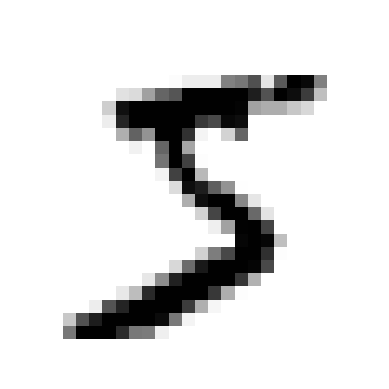

In [6]:
import matplotlib.pyplot as plt

def plot_digit(image_data):
    image = image_data.reshape(28,28)
    plt.imshow(image, cmap="binary")
    plt.axis("off")

some_digit = X[0]
plot_digit(some_digit)
plt.show()

In [7]:
y[0]

'5'

In [8]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# 训练二元分类器

先简化问题，只尝试识别一个数字。例如检测是否是数字'5'

In [9]:
y_train_5 = (y_train == '5')  # True for all 5s, False for all other digits
y_test_5 = (y_test == '5')

In [10]:
y_train_5

array([ True, False, False, ...,  True, False, False])

In [11]:
y_test_5

array([False, False, False, ..., False,  True, False])

## 随机梯度下降

In [12]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

使用它来进行预测

In [13]:
sgd_clf.predict([some_digit])

array([ True])

# 性能指标

## 使用交叉验证测量准确率

In [14]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

准确率都超过了95%，让我们看一个DummyClassifier

In [15]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train_5)
print(any(dummy_clf.predict(X_train)))

False


In [16]:
cross_val_score(dummy_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.90965, 0.90965, 0.90965])

仍然超过90%。这仅仅是因为大约 10％的图像是 5，所以如果您总是猜测一幅图像不是 5，您将有 90％的准确率。

分类器的首选性能指标不是**准确率**，而是**混淆矩阵**


## 混淆矩阵

混淆矩阵的一般思想是计算类 A 的实例被分类为类 B 的次数，对于所有 A/B 对。例如，要知道分类器将 8 的图像误判为 0 的次数，您将查看混淆矩阵的第 8 行，第 0 列。

In [17]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
y_train_pred

array([ True, False, False, ...,  True, False, False])

In [18]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_train_5, y_train_pred)
cm

array([[53892,   687],
       [ 1891,  3530]])

In [19]:
y_train_perfect_predictions = y_train_5  
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

![](./images/mls3_0303.png)

## 精度和召回率

In [20]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

np.float64(0.8370879772350012)

In [21]:
recall_score(y_train_5, y_train_pred)

np.float64(0.6511713705958311)

现在我们的 `5` 检测器看起来并不像我们在查看其准确性时那么出色。当它声称一幅图像代表 `5` 时，它只有 83.7%的时间是正确的。此外，它只能检测到 65.1%的 `5`。

通常方便将精度和召回率结合成一个称为F<sub>1</sub> 分数的单一指标。F<sub>1</sub>是精度和召回率的调和平均数。调和平均值更加重视低值。因此，只有当召回率和精度都很高时，分类器才会获得高的F<sub>1</sub>分数。

In [22]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

np.float64(0.7325171197343847)

某些起情况下你可能更关心精度/召回率，其中之一。
你不能两全其美：提高精度会降低召回率，反之亦然。这被称为精度/召回率权衡。

图像按其分类器得分排名，高于所选决策阈值的图像被视为正例；阈值越高，召回率越低，但（一般而言）精度越高

## 精度/召回率权衡

SGDClassifier是如何做出分类决策: 。对于每个实例，它根据决策函数计算得分。如果该得分大于阈值，则将实例分配给正类；否则将其分配给负类。

* 降低阈值会增加召回率并降低精度。
* 增加阈值会降低召回率并提高精度。

![](./images/mls3_0304.png)

Scikit-Learn 不允许直接设置阈值。可以调用分类器的decision_function()方法，返回每个实例的得分。

In [23]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [24]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

SGDClassifier使用阈值等于 0

In [25]:
threshold = 3000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

可以看出提高阈值会降低召回率。

如何决定使用哪个阈值？首先，使用cross_val_predict()函数获取训练集中所有实例的分数，但是这次指定要返回决策分数而不是预测：

In [26]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")
y_scores

array([  1200.93051237, -26883.79202424, -33072.03475406, ...,
        13272.12718981,  -7258.47203373, -16877.50840447])

使用这些分数，使用precision_recall_curve()函数计算所有可能阈值的精度和召回率（该函数添加最后一个精度为 0 和最后一个召回率为 1，对应于无限阈值）

In [27]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

使用 Matplotlib 绘制精度和召回率作为阈值值的函数

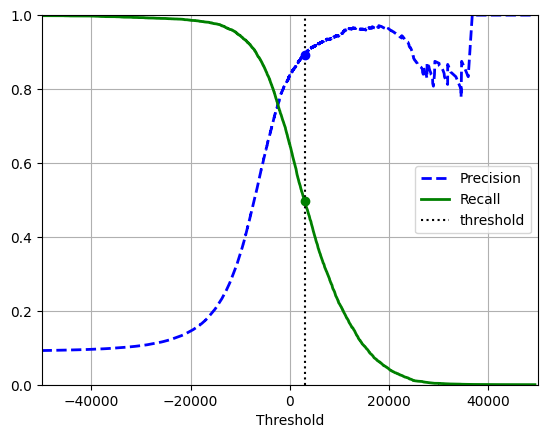

In [28]:
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
plt.vlines(threshold, 0, 1.0, "k", "dotted", label="threshold")

idx = (thresholds >= threshold).argmax()
plt.plot(thresholds[idx], precisions[idx], "bo")
plt.plot(thresholds[idx], recalls[idx], "go")
plt.axis([-50000, 50000, 0, 1])
plt.grid()
plt.xlabel("Threshold")
plt.legend(loc="center right")
plt.show()

为什么精度曲线比召回率曲线更加崎岖？

答：当你提高阈值时，精度有时会下降（尽管通常会上升）。当你从中心阈值开始，将其向右移动一个数字时会发生什么：精度从 4/5（80%）下降到 3/4（75%）。

另一方面，当增加阈值时，召回率只能下降，这解释了为什么其曲线看起来平滑。

![](./images/mls3_0304.png)

选择一个良好的精度/召回率折衷的另一种方法是直接绘制精度与召回率的图表

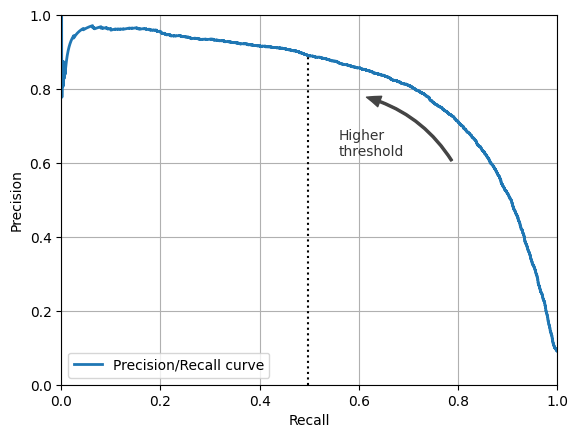

In [29]:
import matplotlib.patches as patches

plt.plot(recalls, precisions, linewidth=2, label="Precision/Recall curve")

plt.plot([recalls[idx], recalls[idx]], [0., precisions[idx]], "k:")

plt.gca().add_patch(patches.FancyArrowPatch(
    (0.79, 0.60), (0.61, 0.78),
    connectionstyle="arc3,rad=.2",
    arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
    color="#444444"))
plt.text(0.56, 0.62, "Higher\nthreshold", color="#333333")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc="lower left")
plt.show()

你可以看到精度在约 80%的召回率处开始急剧下降。你可能希望在该下降之前选择一个精度/召回率折衷，例如在约 60%的召回率处。但是，选择取决于你的项目。

假设你决定追求 90%的精度。你可以使用第一个图表找到需要使用的阈值，但这不太精确。或者，你可以搜索给出至少 90%精度的最低阈值。为此，你可以使用 NumPy 数组的argmax()方法。这将返回最大值的第一个索引，这在这种情况下意味着第一个True值：

In [30]:
idx_for_90_precision = (precisions >=0.90).argmax()
threshold_for_90_precision = thresholds[idx_for_90_precision]
threshold_for_90_precision

np.float64(3370.0194991439594)

要进行预测（目前只是在训练集上），而不是调用分类器的predict()方法，你可以运行这段代码

In [31]:
y_train_pred_90 = (y_scores >= threshold_for_90_precision)

检查这些预测的精度和召回率：

In [32]:
precision_score(y_train_5, y_train_pred_90)

np.float64(0.9000345901072293)

In [33]:
recall_at_90_precision = recall_score(y_train_5, y_train_pred_90)
recall_at_90_precision

np.float64(0.4799852425751706)

## ROC 曲线

ROC 曲线是与二元分类器一起使用的另一个常见工具。它与精度/召回率曲线非常相似，但是 ROC 曲线不是绘制精度与召回率，而是绘制真正例率（召回率的另一个名称）与假正例率（FPR）。FPR（也称为误报率）是被错误分类为正例的负实例的比率。它等于 1 减去真负例率（TNR），即被正确分类为负例的负实例的比率。TNR 也称为特异性。因此，ROC 曲线绘制灵敏度（召回率）与 1-特异性。

使用`roc_curve()`函数计算各种阈值的 TPR 和 FPR：

In [34]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

可以使用 Matplotlib 绘制 FPR 与 TPR。由于在这种情况下，阈值按降序列出，因此我们在第一行上使用`<=`而不是`>=`：

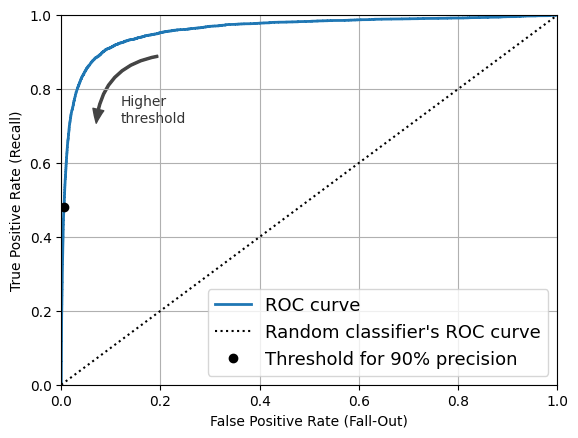

In [35]:
idx_for_threshold_at_90 = (thresholds <= threshold_for_90_precision).argmax()
tpr_90, fpr_90 = tpr[idx_for_threshold_at_90], fpr[idx_for_threshold_at_90]

plt.plot(fpr, tpr, linewidth=2, label="ROC curve")
plt.plot([0, 1], [0, 1], 'k:', label="Random classifier's ROC curve")
plt.plot([fpr_90], [tpr_90], "ko", label="Threshold for 90% precision")

plt.gca().add_patch(patches.FancyArrowPatch(
    (0.20, 0.89), (0.07, 0.70),
    connectionstyle="arc3,rad=.4",
    arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
    color="#444444"))
plt.text(0.12, 0.71, "Higher\nthreshold", color="#333333")
plt.xlabel('False Positive Rate (Fall-Out)')
plt.ylabel('True Positive Rate (Recall)')
plt.grid()
plt.axis([0, 1, 0, 1])
plt.legend(loc="lower right", fontsize=13)
plt.show()

召回率（TPR）越高，分类器产生的假阳性（FPR）就越多。虚线代表纯随机分类器的 ROC 曲线；一个好的分类器尽可能远离该线（朝向左上角）

比较分类器的一种方法是测量曲线下面积（AUC）。完美的分类器的 ROC AUC 等于 1。

In [36]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

np.float64(0.9604938554008616)

ROC 曲线与精确率/召回率（PR）曲线非常相似，您可能想知道如何决定使用哪个?

当正类别很少或您更关心假阳性而不是假阴性时，应优先选择 PR 曲线。否则，请使用 ROC 曲线

例如，查看先前的 ROC 曲线（以及 ROC AUC 分数），您可能会认为分类器非常好。但这主要是因为与负例（非 5）相比，正例（5）很少。相比之下，PR 曲线清楚地表明分类器有改进的空间：曲线实际上可以更接近右上角

`RandomForestClassifier`和`SGDClassifier`进行对比

In [37]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)

`precision_recall_curve()`函数期望每个实例的`标签`和`分数`。由于`RandomForestClassifier`类的工作方式，它没有`decision_function()`方法。幸运的是，它有一个predict_proba()方法，为每个实例返回类概率，并且我们可以将正类别的概率作为分数，因此它将正常工作。

In [38]:
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

In [39]:
y_probas_forest[:2]

array([[0.11, 0.89],
       [0.99, 0.01]])

第二列包含正类别的估计概率，因此让我们将它们传递给`precision_recall_curve()`函数：

In [40]:
y_scores_forest = y_probas_forest[:, 1]
precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(y_train_5, y_scores_forest)

PR 曲线

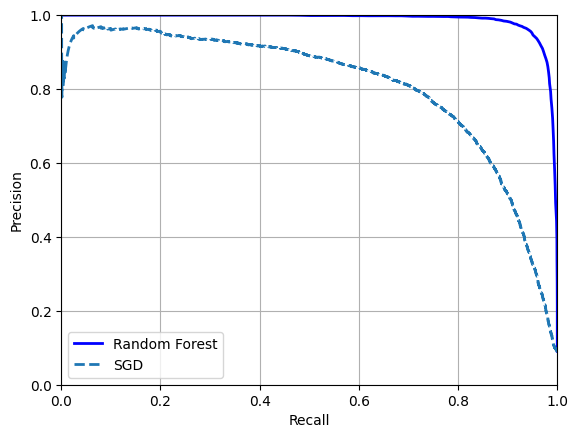

In [41]:
plt.plot(recalls_forest, precisions_forest, "b-", linewidth=2, label="Random Forest")
plt.plot(recalls, precisions, "--", linewidth=2, label="SGD")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc="lower left")
plt.show()

`RandomForestClassifier`的 PR 曲线看起来比`SGDClassifier`的要好得多：它更接近右上角。它的 F<sub>1</sub>分数和 ROC AUC 分数也显著更好

In [42]:
y_train_pred_forest = y_probas_forest[:, 1] >= 0.5 
f1_score(y_train_5, y_train_pred_forest)

np.float64(0.9274509803921569)

In [43]:
roc_auc_score(y_train_5, y_scores_forest)

np.float64(0.9983436731328145)

In [44]:
precision_score(y_train_5, y_train_pred_forest)

np.float64(0.9897468089558485)

In [45]:
recall_score(y_train_5, y_train_pred_forest)

np.float64(0.8725327430363402)

## 多类分类（Multiclass Classification）

一些 Scikit-Learn 分类器（例如`LogisticRegression`、`RandomForestClassifier`和`GaussianNB`）能够本地处理多个类别。其他严格的二元分类器（例如`SGDClassifier`和`SVC`）。然而，有各种策略可用于使用多个二元分类器执行多类分类。

一对剩余（OvR）策略，有时也称为一对所有（OvA）: 创建一个能够将数字图像分类为 10 个类别（从 0 到 9）的系统的一种方法是训练 10 个二元分类器，每个数字一个（一个 0 检测器，一个 1 检测器，一个 2 检测器，依此类推）。

一对一（OvO）策略: 一个用于区分 0 和 1，另一个用于区分 0 和 2，另一个用于 1 和 2，依此类推。

一些算法（如支持向量机分类器）随着训练集的大小而扩展得很差。对于这些算法，OvO 更受青睐，因为在小训练集上训练许多分类器比在大训练集上训练少数分类器要快。然而，对于大多数二元分类算法，OvR 更受青睐。

Scikit-Learn 会检测到您尝试将二元分类算法用于多类分类任务时，并根据算法自动运行 OvR 或 OvO。让我们尝试使用`sklearn.svm.SVC`类中的支持向量机分类器。我们只会在前 2,000 幅图像上进行训练，否则会花费很长时间

In [46]:
from sklearn.svm import SVC

svm_clf = SVC(random_state=42)
svm_clf.fit(X_train[:2000], y_train[:2000])

SVC(random_state=42)

Scikit-Learn 使用了 OvO 策略并训练了 45 个二元分类器。现在让我们对一幅图像进行预测：

In [47]:
svm_clf.predict([some_digit])

array(['5'], dtype=object)

这是正确的！这段代码实际上进行了 45 次预测——每对类别一次——并选择了赢得最多决斗的类别。如果调用decision_function()方法，您会看到它为每个实例返回 10 个分数：每个类别一个。每个类别得分等于赢得的决斗数加上或减去一个小调整（最大±0.33）以打破平局，基于分类器的分数

In [48]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores.round(2)

array([[ 3.79,  0.73,  6.06,  8.3 , -0.29,  9.3 ,  1.75,  2.77,  7.21,
         4.82]])

In [49]:
class_id = some_digit_scores.argmax()
class_id

np.int64(5)

当分类器训练完成时，它会将目标类别列表存储在其classes_属性中，按值排序。

In [50]:
svm_clf.classes_

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype=object)

In [51]:
svm_clf.classes_[class_id]

'5'

如果您想强制 `Scikit-Learn` 使用一对一或一对多，您可以使用`OneVsOneClassifier`或`OneVsRestClassifier`类。只需创建一个实例并将分类器传递给其构造函数（甚至不必是二元分类器）。例如，此代码使用 OvR 策略基于SVC创建一个多类分类器

In [52]:
from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC(random_state=42))
ovr_clf.fit(X_train[:2000], y_train[:2000])

OneVsRestClassifier(estimator=SVC(random_state=42))

In [53]:
ovr_clf.predict([some_digit])

array(['5'], dtype='<U1')

In [54]:
len(ovr_clf.estimators_)

10

在多类数据集上训练SGDClassifier并使用它进行预测同样简单

In [55]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array(['3'], dtype='<U1')

哎呀，那是错误的。预测错误确实会发生！这次 Scikit-Learn 在幕后使用了 OvR 策略：由于有 10 个类别，它训练了 10 个二元分类器。decision_function()方法现在返回每个类别的一个值。让我们看看 SGD 分类器为每个类别分配的分数：

In [56]:
sgd_clf.decision_function([some_digit]).round()

array([[-31893., -34420.,  -9531.,   1824., -22320.,  -1386., -26189.,
        -16148.,  -4604., -12051.]])

您会希望对这个分类器进行多个图像的评估。由于每个类别中的图像数量大致相同，准确度指标是可以接受的。通常情况下，您可以使用cross_val_score()函数来评估模型：

In [57]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

它在所有测试折叠上都超过了 85.8%。如果使用随机分类器，您将获得 10%的准确率，因此这并不是一个很差的分数。

但您仍然可以做得更好。简单地缩放输入可以将准确率提高到 89.1%以上：

In [58]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype("float64"))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

## 错误分析

首先，看一下混淆矩阵。为此，您首先需要使用`cross_val_predict()`函数进行预测；然后您可以将标签和预测传递给`confusion_matrix()`函数，就像您之前所做的那样。然而，由于现在有 10 个类别而不是 2 个，混淆矩阵将包含相当多的数字，可能难阅读。

彩色混淆矩阵图表更容易分析。要绘制这样的图表，请使用`ConfusionMatrixDisplay.from_predictions()`函数，如下所示

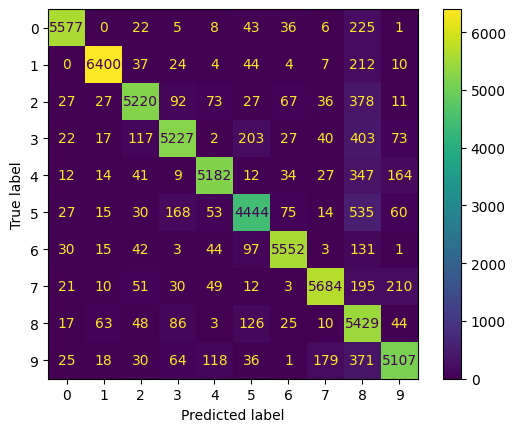

In [59]:
from sklearn.metrics import ConfusionMatrixDisplay

y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred)
plt.show()

这个混淆矩阵看起来相当不错：大多数图像都在主对角线上，这意味着它们被正确分类了。

如果数据集中每个数字的数量不同，这种绝对个数的显示可能有点不妥。这就是通过将每个值除以相应（真实）类别中图像的总数（即除以行的总和）来对混淆矩阵进行归一化的重要性。

这可以通过简单地设置normalize="true"来完成。我们还可以指定values_format=".0%"参数以显示没有小数的百分比。

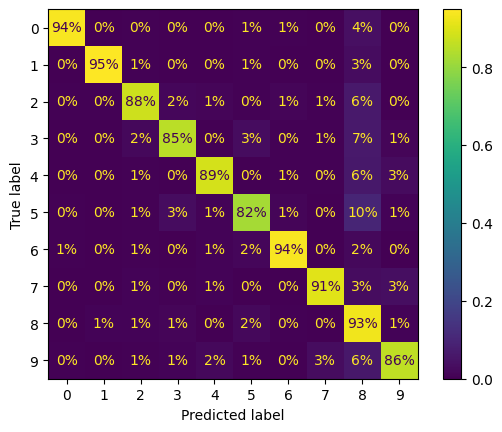

In [60]:
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred,
                                        normalize="true", values_format=".0%")
plt.show()

只有 82%的 5 的图像被正确分类。模型在 5 的图像中最常见的错误是将它们错误分类为 8。

如果你仔细观察，你会注意到许多数字被错误分类为 8，但从这个图表中并不立即明显。如果你想让错误更加突出，你可以尝试在正确预测上设置零权重。以下代码就是这样做的

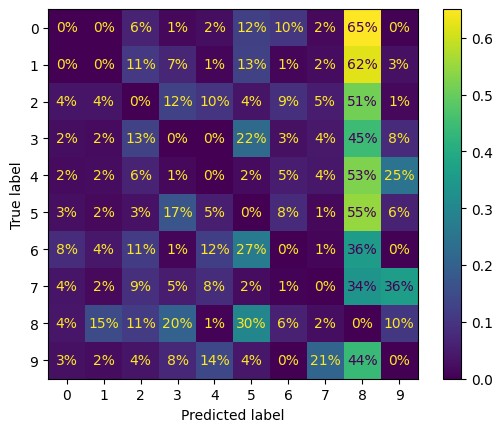

In [61]:
sample_weight = (y_train_pred != y_train)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred,
                                        sample_weight=sample_weight,
                                        normalize="true", values_format=".0%")
plt.show()

现在你可以更清楚地看到分类器所犯的错误类型。类别 8 的列现在非常亮，这证实了许多图像被错误分类为 8。

但要注意如何解释这个图表中的百分比：记住我们已经排除了正确的预测。例如，第 7 行第 9 列的 36% 不意味着 36%的所有 7 的图像被错误分类为 9。它意味着 36%的模型在 7 的图像上犯的错误被错误分类为 9。

也可以通过列而不是通过行对混淆矩阵进行归一化：如果设置normalize="pred"

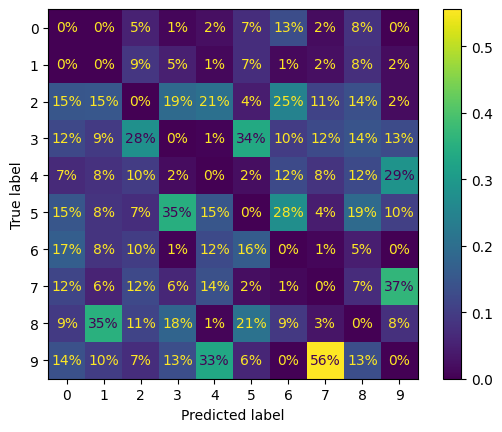

In [62]:
sample_weight = (y_train_pred != y_train)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred,
                                        sample_weight=sample_weight,
                                        normalize="pred", values_format=".0%")
plt.show()

你可以看到 56% 的错误分类的 7 实际上是 9。

分析混淆矩阵通常可以让你了解如何改进你的分类器。从这些图表中看，你的努力应该花在减少错误的 8 上。

例如，你可以尝试收集更多看起来像 8 的（但实际上不是）数字的训练数据，这样分类器就可以学会区分它们和真正的 8。

或者你可以设计新的特征来帮助分类器，例如，编写一个算法来计算闭环的数量（例如，8 有两个，6 有一个，5 没有）。

或者你可以预处理图像（例如，使用 Scikit-Image、Pillow 或 OpenCV）使一些模式，如闭环，更加突出。

分析单个错误也是了解你的分类器在做什么以及为什么失败的好方法。例如，让我们以混淆矩阵样式绘制 3 和 5 的示例

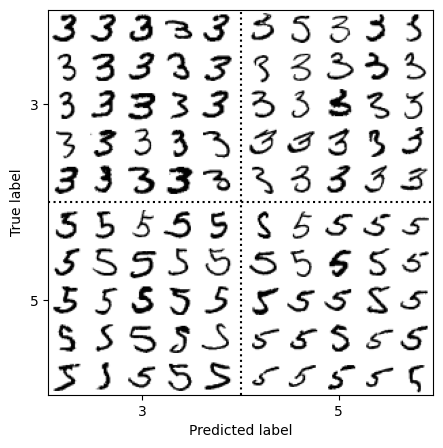

In [63]:
cl_a, cl_b = '3', '5'

X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

size = 5
pad = 0.2
plt.figure(figsize=(size, size))
for images, (label_col, label_row) in [(X_ba, (0, 0)), (X_bb, (1, 0)),
                                       (X_aa, (0, 1)), (X_ab, (1, 1))]:
    for idx, image_data in enumerate(images[:size*size]):
        x = idx % size + label_col * (size + pad)
        y = idx // size + label_row * (size + pad)
        plt.imshow(image_data.reshape(28, 28), cmap="binary",
                   extent=(x, x + 1, y, y + 1))
plt.xticks([size / 2, size + pad + size / 2], [str(cl_a), str(cl_b)])
plt.yticks([size / 2, size + pad + size / 2], [str(cl_b), str(cl_a)])
plt.plot([size + pad / 2, size + pad / 2], [0, 2 * size + pad], "k:")
plt.plot([0, 2 * size + pad], [size + pad / 2, size + pad / 2], "k:")
plt.axis([0, 2 * size + pad, 0, 2 * size + pad])
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()

回想一下，我们使用了一个简单的`SGDClassifier`，它只是一个线性模型：它只是为每个像素分配一个类别权重，当它看到一个新的图像时，它只是将加权像素强度相加以获得每个类别的得分。由于 3 和 5 之间只相差几个像素，这个模型很容易混淆它们。

3s 和 5s 之间的主要区别是连接顶线和底部弧线的小线的位置。如果你画一个 3，连接处稍微向左移动，分类器可能会将其分类为 5，反之亦然。换句话说，这个分类器对图像的移动和旋转非常敏感。减少 3/5 混淆的一种方法是预处理图像，确保它们居中且旋转不太多。然而，这可能并不容易，因为它需要预测每个图像的正确旋转。一个更简单的方法是通过增加训练集中略微移动和旋转的变体来增强训练集。这将迫使模型学会更容忍这些变化。

## 多标签分类

到目前为止，每个实例总是被分配到一个类。但在某些情况下，您可能希望您的分类器为每个实例输出多个类。考虑一个人脸识别分类器：如果它在同一张图片中识别出几个人，它应该做什么？它应该为它识别出的每个人附上一个标签。

In [64]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= "7")
y_train_odd = (y_train.astype("int8") % 2 == 1)

y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

这段代码创建一个包含每个数字图像两个目标标签的y_multilabel数组：第一个指示数字是否大（7、8 或 9），第二个指示数字是否奇数。然后代码创建一个KNeighborsClassifier实例，支持多标签分类（并非所有分类器都支持），并使用多目标数组训练这个模型。现在您可以进行预测，并注意到它输出了两个标签：

In [65]:
knn_clf.predict([some_digit])

array([[False,  True]])

有许多方法可以评估多标签分类器，选择正确的度量标准取决于您的项目。一种方法是测量每个单独标签的 F<sub>1</sub>分数（或之前讨论过的任何其他二元分类器度量标准），然后简单地计算平均分数。以下代码计算所有标签的平均 F<sub>1</sub>分数

In [66]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

np.float64(0.9764102655606048)

这种方法假设所有标签都同等重要，但这可能并非总是如此。特别是，如果您有比 Bob 或 Charlie 更多的 Alice 图片，您可能希望在 Alice 图片上给分类器的分数更多的权重。一个简单的选择是为每个标签赋予一个权重，等于其支持（即具有该目标标签的实例数）。要做到这一点，只需在调用f1_score()函数时设置average="weighted"

如果您希望使用不原生支持多标签分类的分类器，比如SVC，一种可能的策略是为每个标签训练一个模型。然而，这种策略可能难以捕捉标签之间的依赖关系。例如，一个大数字（7、8 或 9）是奇数的可能性是偶数的两倍，但“奇数”标签的分类器不知道“大”标签的分类器预测了什么。为了解决这个问题，模型可以被组织成一个链：当一个模型做出预测时，它使用输入特征加上链中之前所有模型的预测。

In [67]:
from sklearn.multioutput import ClassifierChain

chain_clf = ClassifierChain(SVC(), cv=3, random_state=42)
chain_clf.fit(X_train[:2000], y_multilabel[:2000])

ClassifierChain(base_estimator=SVC(), cv=3, random_state=42)

In [68]:
chain_clf.predict([some_digit])

array([[0., 1.]])

## 多输出分类

这是多标签分类的一种泛化，其中每个标签可以是多类别的（即，它可以有两个以上的可能值）

为了说明这一点，让我们构建一个从图像中去除噪声的系统。它将以嘈杂的数字图像作为输入，然后（希望）输出一个干净的数字图像，表示为像 MNIST 图像一样的像素强度数组。请注意，分类器的输出是多标签的（每个像素一个标签），每个标签可以有多个值（像素强度范围从 0 到 255）。因此，这是一个多输出分类系统的示例

让我们从使用 NumPy 的randint()函数向 MNIST 图像添加噪声来创建训练集和测试集。目标图像将是原始图像

In [69]:
np.random.seed(42)  # to make this code example reproducible
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

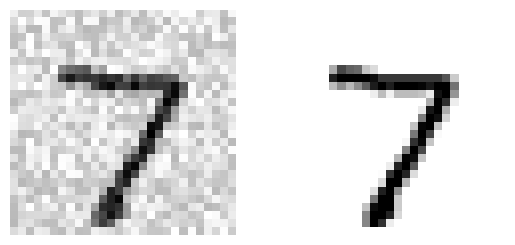

In [70]:
plt.subplot(121); plot_digit(X_test_mod[0])
plt.subplot(122); plot_digit(y_test_mod[0])
plt.show()

左边是嘈杂的输入图像，右边是干净的目标图像。现在让我们训练分类器，让它清理这幅图像

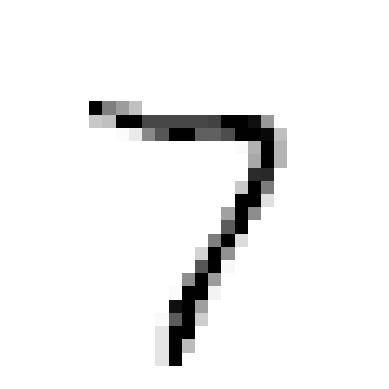

In [71]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[0]])
plot_digit(clean_digit)
plt.show()